In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# Introduction

> Convolutional Neural Networks (ConvNets or CNNs) are a category of Neural Networks that have proven very effective in areas such as image recognition and classification. ConvNets have been successful in identifying faces, objects and traffic signs apart from powering vision in robots and self driving cars. [1]

Reference:
[1] https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

# Load Data From Pickle Files

>Here I will explain how to use CNN to get the prediction of a dataset of faces from my personal data using pickle

In [2]:
pickle_X = open("Face_Recognition_X.pickle","rb")
X = pickle.load(pickle_X)
pickle_y = open("Face_Recognition_y.pickle","rb")
y = pickle.load(pickle_y)

# Train Test Split

> Using Train Test Split, the X_train & X_test is the dependent variables with the 2500 pixels dataset and the y_train & y_test is the independent variable with the 3 different classes dataset. It separated into 80% training set and 20% testing set in random order.

In [3]:
# Load the data, split between train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

# Preparing The Data

In [4]:
# Define the input image dimensions
img_rows, img_cols = 50, 50

# range of x values
print(f'X range: {X_train.min()}-{X_train.max()}')

# y unique values
print(f'y values: {np.unique(y_train)}')

# Define number of classes
num_classes = len(np.unique(y_train))
print(f'Number of classes: {num_classes}')

X range: 0-255
y values: [0 1 2]
Number of classes: 3


In [5]:
# Reshape for Keras model types
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (5758, 50, 50, 1)
X_test shape: (1440, 50, 50, 1)


>Here, it modifies the pixel values to fall between 0 and 1 before passing the values into the CNN.

In [6]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(f'X_train range: {X_train.min()}-{X_train.max()}')

X_train range: 0.0-1.0


# Building the model architecture

In [7]:
# Create simple CNN model architecture with Pooling for dimensionality reduction 
CNN_model = Sequential()

CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (50, 50, 1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Conv2D(256, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Dropout(0.25))

CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dropout(0.25))
CNN_model.add(Dense(256, activation='relu'))
CNN_model.add(Dense(num_classes, activation='softmax'))

CNN_model.summary()

CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

history = CNN_model.fit(X_train, y_train,
              batch_size = 128,
              epochs = 10,
              verbose = 1,
              validation_data = (X_test, y_test))


## SAVING THE CNN MODEL TO JSON FILE

#fer_json = CNN_model.to_json()
#with open("fer.json", "w") as json_file:
#    json_file.write(fer_json)
#CNN_model.save_weights("fer.h5")
#print('done')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 256)         295168    
__________

# Accuracy and Loss Graph

>Refer to the graphs below, it shows that the testing accuracy starts to stabilize after the 7th epochs between 98% and 99% accuracy.  Also, the training loss is becoming much smaller than the testing loss after the 7th epochs. This is because the model itself starts to overfit the training dataset after too much iterations. To prevent overfitting, I can reduce the number epochs. Otherwise, the result was pretty good. The machine was able to differentiate between Austin, sister and Unknown with high accuracy result.

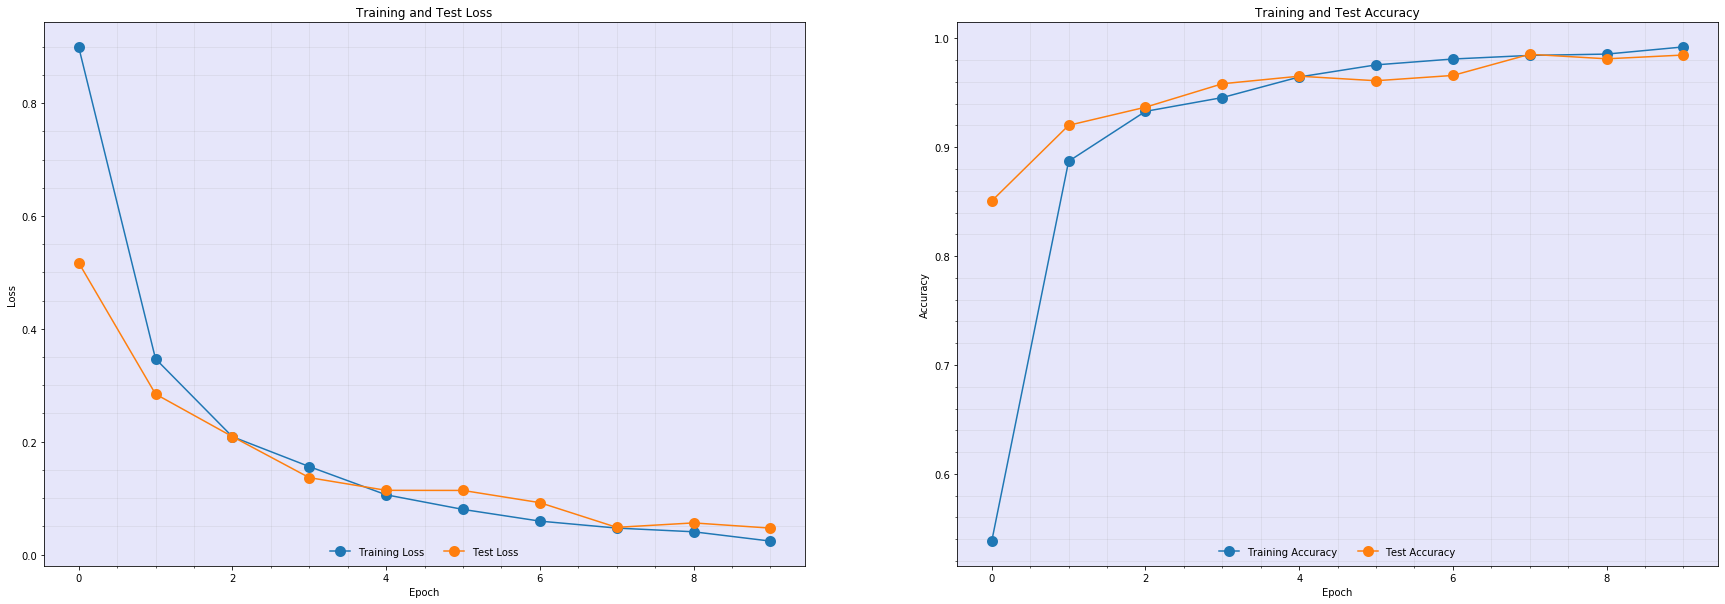

In [8]:
# The Accuracy and Loss Graphs between training and test
fig, ax = plt.subplots(1,2,figsize=(30, 10))

ax[0].plot(history.history['loss'], marker='o', label='Training Loss',markeredgewidth=5)
ax[0].plot(history.history['val_loss'], marker='o', label='Test Loss',markeredgewidth=5)
ax[0].set_title('Training and Test Loss')
ax[0].legend(frameon=False, loc='lower center', ncol=2)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(color='#666666', linestyle='-.', linewidth=0.7,which='minor')
ax[0].minorticks_on()
ax[0].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax[0].set_facecolor("#E6E6FA")

ax[1].plot(history.history['acc'], marker='o', label='Training Accuracy',markeredgewidth=5)
ax[1].plot(history.history['val_acc'], marker='o', label='Test Accuracy',markeredgewidth=5)
ax[1].set_title('Training and Test Accuracy')
ax[1].legend(frameon=False, loc='lower center', ncol=2)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].grid(color='#666666', linestyle='-.', linewidth=0.7,which='minor')
ax[1].minorticks_on()
ax[1].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax[1].set_facecolor("#E6E6FA")

> Here, I used a relatively simple CNN architecture with 4 convolutional layers and 2 Fully connected layers to achieve testing accuracy of 98% for recognizing 3 classes

In [9]:
score = CNN_model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

1440/1440 [==============================] - 2s 1ms/step
Test loss: 0.04685900106572565
Test accuracy: 0.9847222222222223


# Confusion Matrix

In [10]:
Type = ["Unknown","Austin","Sister"]
predict = CNN_model.predict_classes(X_test)
con_mat = confusion_matrix(y_test,predict)
percentage_con_mat = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

In [11]:
normal_df = pd.DataFrame(percentage_con_mat,index = Type,columns =  Type)
percentage_df = pd.DataFrame(con_mat,index = Type,columns =  Type)

>The confusion matrix plots below show that the Face Recognition model has very significant result for predicting myself, sister and Unknown.

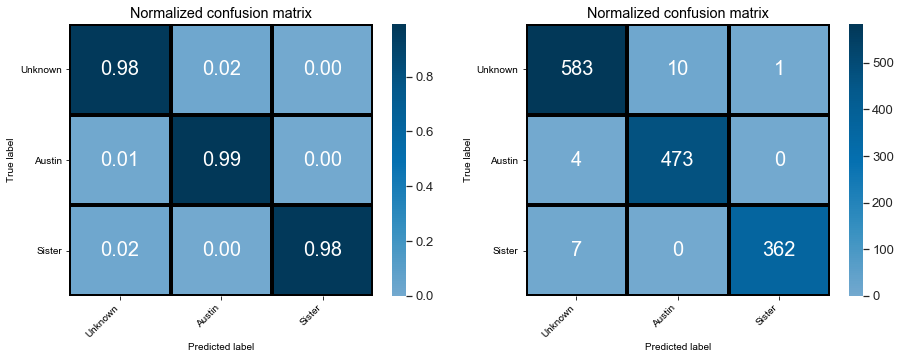

In [12]:
# The Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

sns.set(font_scale=1.2)
plot1 = sns.heatmap(normal_df,center=0,annot=True,fmt = '.2f',linewidths=3,cmap="PuBu",
                    annot_kws={"size": 20},ax=ax[0],linecolor='black')
plot1.set_title('Normalized confusion matrix')
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45, horizontalalignment='right');
plot1.set_yticklabels(plot1.get_yticklabels(), rotation=0, horizontalalignment='right');
plot1.set_ylabel('True label');
plot1.set_xlabel('Predicted label');

plot2 = sns.heatmap(percentage_df,center=0,annot=True, fmt="d",linewidths=3,cmap="PuBu",
                    annot_kws={"size": 20},ax=ax[1],linecolor='black')
plot2.set_title('Normalized confusion matrix')
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45, horizontalalignment='right');
plot2.set_yticklabels(plot2.get_yticklabels(), rotation=0, horizontalalignment='right');
plot2.set_ylabel('True label');
plot2.set_xlabel('Predicted label');

# Image Testing

>Using Haar Cascade Classifier, it helps remove the background noise and crop the frontal face image.

In [13]:
def faceDetection(test_img):
    face_haar_cascade=cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    faces=face_haar_cascade.detectMultiScale(test_img,scaleFactor=1.32,minNeighbors=5)

    return faces,test_img

In [14]:
path1 = 'Recognition_Test/IMG_3626.jpg'
path2 = 'Recognition_Test/Kangana.jpg'
path3 = 'Recognition_Test/612552B0-C7B5-473D-B65C-FEE6A779159E-1307-000000B593B8B48A.jpg'
path = [path1,path2,path3]

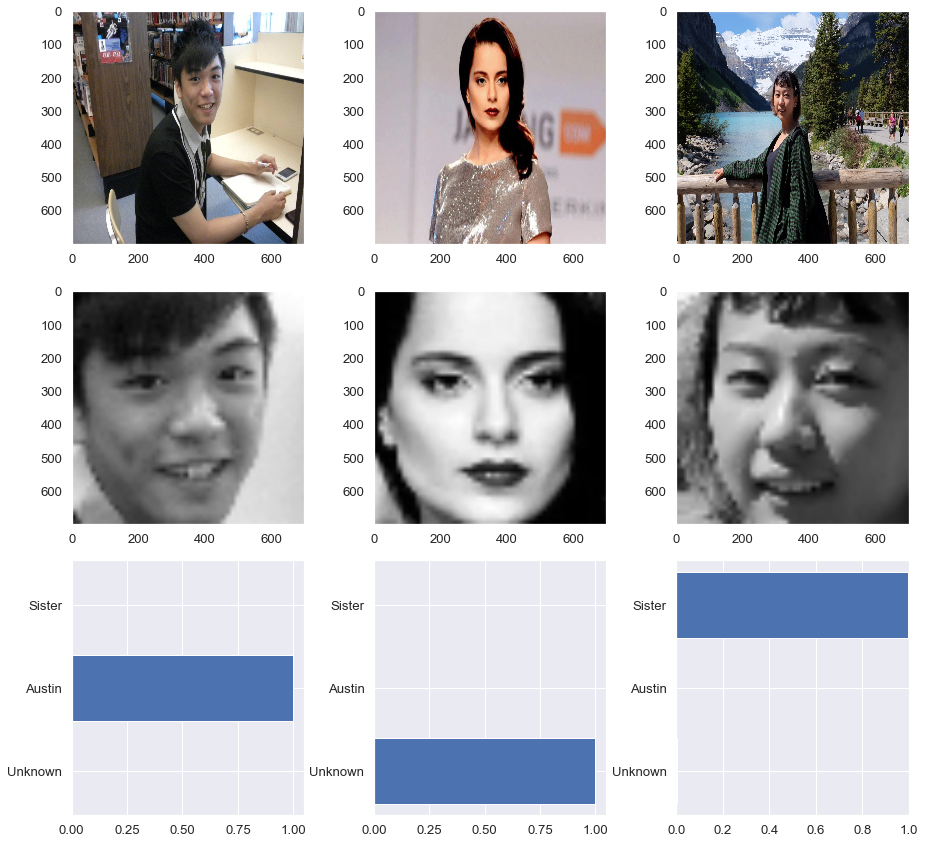

In [15]:
fig, ax = plt.subplots(3, 3,figsize=(15, 15))

for i in range (0,3):
    
# Origin Image
        image = plt.imread(path[i])
        ax[0,i].imshow(cv2.resize(image,(700, 700)))
        ax[0,i].grid(False)
        
# Frontal Face Image
        img = cv2.imread(path[i],cv2.IMREAD_GRAYSCALE)
        faces_rect,test_img=faceDetection(img)
        (x,y,w,h)=faces_rect[0]
        roi_gray=test_img[y:y+w,x:x+h]
        new_array = cv2.resize(roi_gray,(img_rows, img_cols))
        ax[1,i].imshow(cv2.resize(new_array,(700, 700)),cmap = 'gray')
        ax[1,i].grid(False)
    
# Prediction Bar Graph 
        x_img = new_array.reshape(1, img_rows, img_cols, 1)
        a_img = x_img.astype('float32')
        a_img /= 255
        predict = CNN_model.predict(a_img)
        predict_prob = CNN_model.predict_proba(a_img)
        pltx = pd.DataFrame(Type)
        pltx = pltx.rename(columns={ 0 : "Type"})
        plty = pd.DataFrame(predict_prob).T
        plty = plty.rename(columns={ 0 : "Precent"});
        ans = pd.concat([pltx, plty],axis =1)
        ax[2,i].barh(ans['Type'],ans['Precent'])
        plt.xlim(0,1)

plt.subplots_adjust(wspace=0.3, hspace=0.1)